### **Note**
Paths for the symlinks created throughout the notebook will need to be adjusted on a per machine basis to point to the folders created while generating feature maps in the ```Maps.ipynb``` notebook.

In [1]:
![ ! -e Code ]  && ln -s .. Code

# Imports

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time
from torch.utils.data import DataLoader
from torchvision import transforms
from Code.gram import GRAM_RTM
from Code.act_maps import ActivationMaps
from Code.rcnn_models.linear_2_conv_1 import BackboneTail as Linear2Conv1
from Code.rcnn import RCNN

# Datasets

In [2]:
gram_dataset_val = GRAM_RTM(prefix="GRAM", split="val", detectron=True)
gram_dataset_test = GRAM_RTM(prefix="GRAM", split="test", detectron=True)
act_map_dataset_train = ActivationMaps(prefix="GRAM", split="train")
act_map_dataset_val = ActivationMaps(prefix="GRAM", split="val")
act_map_dataset_test = ActivationMaps(prefix="GRAM", split="test")
act_map_dataloader_train = DataLoader(act_map_dataset_train, batch_size=16, shuffle=True)

# Methods

In [3]:
import torch.nn.functional as F
criterion = F.cross_entropy

def train(loader, model, optimizer):
    '''
    Train the model for one epoch.
    '''
    for batch_idx, batch in enumerate(loader):
        inputs, targets = batch[0].cuda(), batch[1].cuda()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

# Accuracy & Speed (Long Training)

In [14]:
!rm GRAM/maps && ln -s ~/HDD/mask_maps_50_small GRAM/maps
NUM_EPOCHS = 15

### 2 Linear + 1 Conv

In [15]:
model = Linear2Conv1().cuda()
optimizer = optim.Adam(model.parameters())
for epoch in range(NUM_EPOCHS):
    print(f'\r{epoch + 1}\t', end='')
    train(act_map_dataloader_train, model, optimizer)

15	

In [16]:
correct, total_time = 0, 0
with torch.no_grad():
    for i in range(len(act_map_dataset_val)):
        print(f'\r{i}\t', end='')
        image, target = act_map_dataset_val[i]
        image = image.cuda().unsqueeze(0)
        start_time = time()
        output = model(image)
        total_time += time() - start_time
        num_cars = torch.argmax(output, dim=1).cpu().item()
        if num_cars == target.item(): correct += 1
    for i in range(len(act_map_dataset_test)):
        print(f'\r{i}\t', end='')
        image, target = act_map_dataset_test[i]
        image = image.cuda().unsqueeze(0)
        start_time = time()
        output = model(image)
        total_time += time() - start_time
        num_cars = torch.argmax(output, dim=1).cpu().item()
        if num_cars == target.item(): correct += 1
l2c1_acc, l2c1_time = 100. * correct / (1504 * 2), total_time / (1504 * 2)

1503	

### Mask RCNN

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x.numpy().transpose(1, 2, 0) * 255)
])

In [8]:
model = RCNN(rcnn_type="M50")
correct, total_time = 0, 0
with torch.no_grad():
    for i in range(len(gram_dataset_val)):
        print(f'\r1 - {i}\t', end='')
        image, target = gram_dataset_val[i]
        image = transform(image)
        start_time = time()
        output = model.forward(image)
        total_time += time() - start_time
        start_time = time()
        image = transforms.ToTensor()(image).cuda().unsqueeze(0)
        model.predictor.model.backbone(image)
        total_time -= time() - start_time
        if output == target.item(): correct += 1
    for i in range(len(gram_dataset_test)):
        print(f'\r2 - {i}\t', end='')
        image, target = gram_dataset_test[i]
        image = transform(image)
        start_time = time()
        output = model.forward(image)
        total_time += time() - start_time
        start_time = time()
        image = transforms.ToTensor()(image).cuda().unsqueeze(0)
        model.predictor.model.backbone(image)
        total_time -= time() - start_time
        if output == target.item(): correct += 1
mrcnn_acc, mrcnn_time = 100. * correct / (1504 * 2), total_time / (1504 * 2)

1 - 0	

/home/rodrigo/.local/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


2 - 1503	

### Mask RCNN

In [9]:
model = RCNN(rcnn_type="F50")
correct, total_time = 0, 0
with torch.no_grad():
    for i in range(len(gram_dataset_val)):
        print(f'\r1 - {i}\t', end='')
        image, target = gram_dataset_val[i]
        image = transform(image)
        start_time = time()
        output = model.forward(image)
        total_time += time() - start_time
        start_time = time()
        image = transforms.ToTensor()(image).cuda().unsqueeze(0)
        model.predictor.model.backbone(image)
        total_time -= time() - start_time
        if output == target.item(): correct += 1
    for i in range(len(gram_dataset_test)):
        print(f'\r2 - {i}\t', end='')
        image, target = gram_dataset_test[i]
        image = transform(image)
        start_time = time()
        output = model.forward(image)
        total_time += time() - start_time
        start_time = time()
        image = transforms.ToTensor()(image).cuda().unsqueeze(0)
        model.predictor.model.backbone(image)
        total_time -= time() - start_time
        if output == target.item(): correct += 1
frcnn_acc, frcnn_time = 100. * correct / (1504 * 2), total_time / (1504 * 2)

2 - 1503	

### Test Accuracy

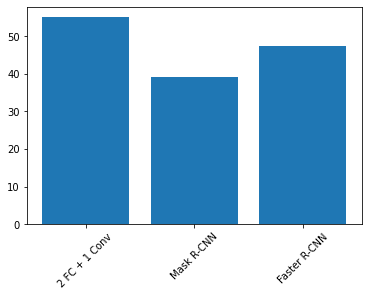

In [17]:
labels = ('2 FC + 1 Conv', 'Mask R-CNN', 'Faster R-CNN')
accs = (l2c1_acc, mrcnn_acc, frcnn_acc)
plt.bar(labels, accs)
plt.xticks(rotation=45);

### Inference Speed

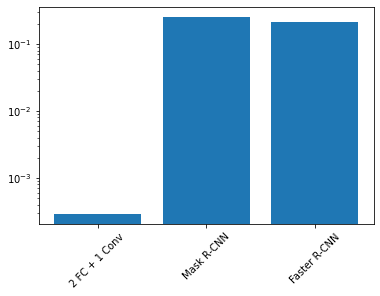

In [13]:
inf_times = (l2c1_time, mrcnn_time, frcnn_time)
plt.bar(labels, inf_times)
plt.xticks(rotation=45);
plt.yscale("log")